In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os, datetime
from matplotlib import pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [3]:
def get_file_names(folder):
    #Listing entries present in given folder
    entries = os.listdir(folder)
    for i in entries:
        if 'csv' not in i:
            entries.remove(i)
    return sorted(entries, reverse=True)[0:12]

train_path = "../split_datasets/train/"
test_path = "../split_datasets/test/"
val_path = "../split_datasets/validation/"

train_files = get_file_names(train_path)
test_files = get_file_names(test_path)
val_files = get_file_names(val_path)

frames = []
for i in train_files:
    frames.append(pd.read_csv(train_path+i))
    break
train_df = pd.concat(frames, sort=False)
train_df = train_df.drop(columns="id")
train_df = train_df.drop(columns="last_scraped")
train_df = train_df.fillna(0)

frames = []
for i in test_files:
    frames.append(pd.read_csv(test_path+i))
    break
test_df = pd.concat(frames, sort=False)
test_df = test_df.drop(columns="id")
test_df = test_df.drop(columns="last_scraped")
test_df = test_df.fillna(0)

frames = []
for i in val_files:
    frames.append(pd.read_csv(val_path+i))
    break
val_df = pd.concat(frames, sort=False)
val_df = val_df.drop(columns="id")
val_df = val_df.drop(columns="last_scraped")
val_df = val_df.fillna(0)

min_price = min(train_df['price'].min(), test_df['price'].min(), val_df['price'].min())
max_price = max(train_df['price'].max(), test_df['price'].max(), val_df['price'].max())
#min_long = min(train_df['longitude'].min(), test_df['longitude'].min(), val_df['longitude'].min())
#max_long = max(train_df['longitude'].max(), test_df['longitude'].max(), val_df['longitude'].max())
min_lat = min(train_df['latitude'].min(), test_df['latitude'].min(), val_df['latitude'].min())
max_lat = max(train_df['latitude'].max(), test_df['latitude'].max(), val_df['latitude'].max())

train_df['price'] = (train_df['price'] - min_price)/(max_price - min_price)
#train_df['longitude'] = (train_df['longitude'] - min_long)/(max_long - min_long)
train_df['latitude'] = (train_df['latitude'] - min_lat)/(max_lat - min_lat)
train_df = train_df.reset_index(drop=True)

test_df['price'] = (test_df['price'] - min_price)/(max_price - min_price)
#test_df['longitude'] = (test_df['longitude'] - min_long)/(max_long - min_long)
test_df['latitude'] = (test_df['latitude'] - min_lat)/(max_lat - min_lat)
test_df = test_df.reset_index(drop=True)

val_df['price'] = (val_df['price'] - min_price)/(max_price - min_price)
#val_df['longitude'] = (val_df['longitude'] - min_long)/(max_long - min_long)
val_df['latitude'] = (val_df['latitude'] - min_lat)/(max_lat - min_lat)
val_df = val_df.reset_index(drop=True)
#train_df = train_df.drop(columns=["minimum_nights", "maximum_nights"])
#test_df = test_df.drop(columns=["minimum_nights", "maximum_nights"])
#val_df = val_df.drop(columns=["minimum_nights", "maximum_nights"])

#print(minimum, maximum)
bounds = [min_price, max_price]

In [22]:
pd.set_option('display.max_rows', None)
train_df.head(1).transpose()

,0
latitude,0.292943
accommodates,2.000000
bathrooms,1.000000
bedrooms,0.000000
beds,2.000000
price,0.047923
amenities_TV,1.000000
amenities_Air conditioning,1.000000
amenities_Kitchen,1.000000
amenities_Indoor fireplace,0.000000


In [9]:
class airbnb_dataset (Dataset):
    def __init__(self, df, purpose):
        self.df = df
        self.price = self.df["price"]
        self.df = self.df.drop(columns="price")
        self.purpose = purpose
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        # Returns specific sample as a dict
        if torch.is_tensor(index):
            index = index.tolist()
        sample = torch.tensor(self.df.iloc[index]).float()
        label = torch.tensor([self.price.iloc[index]]).float()
        return {"sample": sample, "label": label}

In [10]:
train_ds = airbnb_dataset(train_df, "train")
test_ds = airbnb_dataset(test_df, "test")
val_ds = airbnb_dataset(val_df, "test")

train_loader = DataLoader(train_ds, batch_size=1000, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1000, shuffle=False, num_workers=0)

In [11]:
train_ds[0]

{'sample': tensor([0.2929, 2.0000, 1.0000, 0.0000, 2.0000, 1.0000, 1.0000, 1.0000, 0.0000,
         1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 1.0000, 0.0000]), 'label': tensor([0.0479])}

In [30]:
class airbnb_net (nn.Module):
    def __init__(self):
        super(airbnb_net, self).__init__()
        self.layer1 = nn.Linear(66, 66*5)
        self.layer2 = nn.Linear(66*5, 66*5)
        self.layer3 = nn.Linear(66*5, 66*2)
        self.layer4 = nn.Linear(66*2, 1)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        return self.layer4(x)

In [34]:
def train(net, train_loader, val_loader, bounds, folder, lr, num_epoch):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    print("Starting Training...")
    start_time = time.time()
    epochs, losses = [], []
    epochs2, train_error, val_error, train_acc, val_acc = [], [], [], [[],[],[]], [[],[],[]]
    
    for epoch in range(num_epoch):
        epoch_loss = 0
        epoch_time = time.time()
        batch_loss = 0
        batch_time = time.time()
        for i, data in enumerate(train_loader):
            sample = data["sample"]
            label = data["label"]
            output = net(sample)
            loss = criterion(output, label)
            #print(label, output)
            #print(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            batch_loss += loss.item()
            epoch_loss += loss.item()
            if i % 10 == 9:
                batch_loss = batch_loss/10
                print("---[ITER %d] loss: %.6f  time: %.3f" % (i+1, batch_loss, time.time()-batch_time))
                batch_loss = 0
                batch_time = time.time()
        epoch_loss /= len(train_loader)
        
        # Record Loss
        epochs.append(epoch)
        losses.append(epoch_loss)
        
        # Record Error, Accuracy 
        if epoch % 10 == 9:
            epochs2.append(epoch)
            avg_train_error, avg_train_acc, avg_val_error, avg_val_acc = get_error(net, train_loader, val_loader, [10, 20, 30], bounds)
            train_error.append(avg_train_error)
            val_error.append(avg_val_error)
            for i in range(3):
                train_acc[i].append(avg_train_acc[i])
                val_acc[i].append(avg_val_acc[i])
                
            torch.save({
                    'epoch' : epoch,
                    'model_state_dict' : net.state_dict(),
                    'optimizer_state_dict' : optimizer.state_dict(),
                    'epochs' : epochs,
                    'losses' : losses,
                    'epochs2': epochs2,
                    'train_error': train_error,
                    'train_acc': train_acc,
                    'val_error': val_error,
                    'val_acc' : val_acc,
                    'lr' : lr
                }, folder+"/checkpoint/checkpoint_"+'{:04d}'.format(epoch)+".tar")
        
        print("[EPOCH %d] loss: %.6f  time: %.3f" % (epoch+1, epoch_loss, time.time()-epoch_time))
        
        if epoch % 10 == 9:
            plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=False)

    print("=========================================")
    print("Training Completed...")
    print("[FINAL] loss: %.6f  time: %.3f" % (epoch_loss, time.time()-start_time))
          
    # plot loss, error, accuracy
    plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last=True)
    
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : net.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'epochs' : epochs,
        'losses' : losses,
        'epochs2': epochs2,
        'train_error': train_error,
        'train_acc': train_acc,
        'val_error': val_error,
        'val_acc' : val_acc,
        'lr' : lr
    }, folder+"/final/checkpoint_final.tar")
    

def plot_statistics(epochs, losses, epochs2, train_error, val_error, train_acc, val_acc, folder, last = False):
    # plot loss curve
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    if last == False:
        plt.savefig(folder+"/lossplot/lossplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/lossplot_final.png", dpi=150)
    plt.show()
    plt.close()
    
    # plot error curve
    plt.title("Training Error Curve")
    plt.plot(epochs2, train_error, label="Train")
    plt.plot(epochs2, val_error, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Absolute Error (in $)")
    plt.legend(loc='best')

    if last == False:
        plt.savefig(folder+"/errorplot/errorplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/errorplot_final.png", dpi=150)
    plt.show()
    plt.close()

    # plot accuracy curve
    plt.title("Training Accuracy Curve")
    for i in range(3):
        plt.plot(epochs2, train_acc[i], label="Train - Thresh: "+str(i*10+10))
        plt.plot(epochs2, val_acc[i], label="Validation - Thresh: "+str(i*10+10))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    
    if last == False:
        plt.savefig(folder+"/accplot/accplot"+'{:04d}'.format(epochs[-1])+".png", dpi=150)
    else:
        plt.savefig(folder+"/final/accplot_final.png", dpi=150)
    
    plt.show()
    plt.close()
    
    
    return None

In [32]:
def get_error(model, train_loader, val_loader, threshold, bounds):
    train_samples = 0
    train_error = 0
    train_accuracy = [0 for i in threshold]
    for i, data in enumerate(train_loader):
        sample = data["sample"]
        label = data["label"]
        output = net(sample)
        error = abs(label-output)
        for j in range(len(threshold)):
            accurate = (error < float(threshold[j])/float(bounds[1]-bounds[0]))
            train_accuracy[j] += accurate.sum().item()
        train_samples += len(label)
        train_error += error.sum().item()
    avg_train_error = float(train_error)/float(train_samples)*(bounds[1]-bounds[0])
    avg_train_accuracy = [float(a)/float(train_samples) for a in train_accuracy]
    
    val_samples = 0
    val_error = 0
    val_accuracy = [0 for i in threshold]
    for i, data in enumerate(val_loader):
        sample = data["sample"]
        label = data["label"]
        output = net(sample)
        error = abs(label-output)
        for j in range(len(threshold)):
            accurate = (error < float(threshold[j])/float(bounds[1]-bounds[0]))
            val_accuracy[j] += accurate.sum().item()
        val_samples += len(label)
        val_error += error.sum().item()
    avg_val_error = float(val_error)/float(val_samples)*(bounds[1]-bounds[0])
    avg_val_accuracy = [float(a)/float(val_samples) for a in val_accuracy]

    return avg_train_error, avg_train_accuracy, avg_val_error, avg_val_accuracy

Starting Training...
---[ITER 10] loss: 0.050799  time: 12.649
[EPOCH 1] loss: 0.047844  time: 14.572
---[ITER 10] loss: 0.027859  time: 11.680
[EPOCH 2] loss: 0.027719  time: 13.258
---[ITER 10] loss: 0.024644  time: 12.971
[EPOCH 3] loss: 0.024702  time: 14.573
---[ITER 10] loss: 0.023227  time: 12.230
[EPOCH 4] loss: 0.023346  time: 13.815
---[ITER 10] loss: 0.022459  time: 11.612
[EPOCH 5] loss: 0.022655  time: 13.232
---[ITER 10] loss: 0.021905  time: 11.689
[EPOCH 6] loss: 0.022183  time: 13.351
---[ITER 10] loss: 0.021516  time: 10.986
[EPOCH 7] loss: 0.021792  time: 12.606
---[ITER 10] loss: 0.021211  time: 11.217
[EPOCH 8] loss: 0.021466  time: 12.772
---[ITER 10] loss: 0.020898  time: 10.956
[EPOCH 9] loss: 0.021132  time: 12.725
---[ITER 10] loss: 0.020511  time: 10.389
[EPOCH 10] loss: 0.020739  time: 32.886


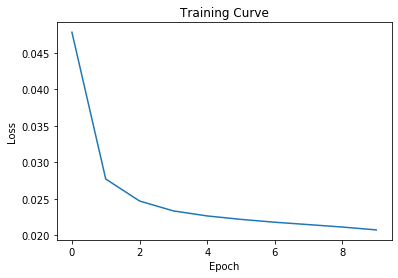

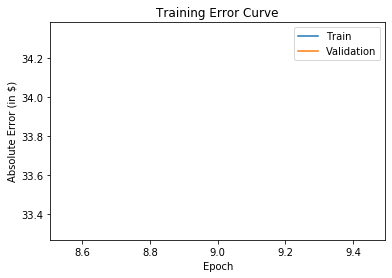

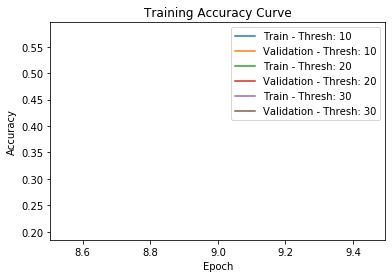

---[ITER 10] loss: 0.020092  time: 10.301
[EPOCH 11] loss: 0.020286  time: 12.031
---[ITER 10] loss: 0.019637  time: 11.778
[EPOCH 12] loss: 0.019814  time: 13.525
---[ITER 10] loss: 0.019171  time: 12.092
[EPOCH 13] loss: 0.019303  time: 13.850
---[ITER 10] loss: 0.018712  time: 13.058
[EPOCH 14] loss: 0.018804  time: 14.831
---[ITER 10] loss: 0.018264  time: 13.728
[EPOCH 15] loss: 0.018321  time: 15.472
---[ITER 10] loss: 0.017789  time: 11.696
[EPOCH 16] loss: 0.017800  time: 13.338
---[ITER 10] loss: 0.017281  time: 11.577
[EPOCH 17] loss: 0.017233  time: 13.551
---[ITER 10] loss: 0.016742  time: 12.829
[EPOCH 18] loss: 0.016669  time: 14.723
---[ITER 10] loss: 0.016113  time: 12.841
[EPOCH 19] loss: 0.016003  time: 14.447
---[ITER 10] loss: 0.015567  time: 11.869
[EPOCH 20] loss: 0.015453  time: 37.059


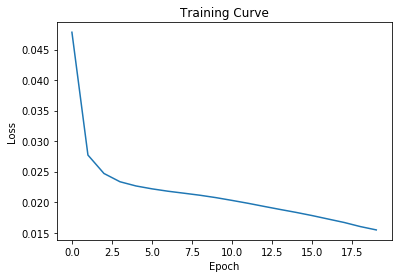

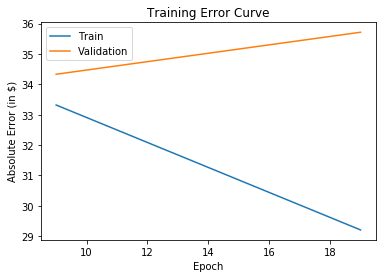

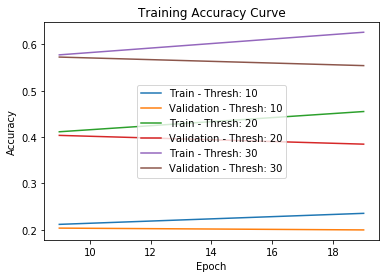

---[ITER 10] loss: 0.015013  time: 12.057
[EPOCH 21] loss: 0.014880  time: 14.921
---[ITER 10] loss: 0.014557  time: 14.551
[EPOCH 22] loss: 0.014405  time: 16.163
---[ITER 10] loss: 0.014163  time: 12.226
[EPOCH 23] loss: 0.013931  time: 14.314
---[ITER 10] loss: 0.014113  time: 11.121
[EPOCH 24] loss: 0.013869  time: 13.001
---[ITER 10] loss: 0.013153  time: 12.299
[EPOCH 25] loss: 0.012855  time: 13.893
---[ITER 10] loss: 0.012468  time: 10.342
[EPOCH 26] loss: 0.012214  time: 12.000
---[ITER 10] loss: 0.011853  time: 11.515
[EPOCH 27] loss: 0.011579  time: 13.144
---[ITER 10] loss: 0.011429  time: 11.359
[EPOCH 28] loss: 0.011157  time: 13.793
---[ITER 10] loss: 0.011040  time: 13.561
[EPOCH 29] loss: 0.010784  time: 15.150
---[ITER 10] loss: 0.010987  time: 13.259
[EPOCH 30] loss: 0.010946  time: 33.867


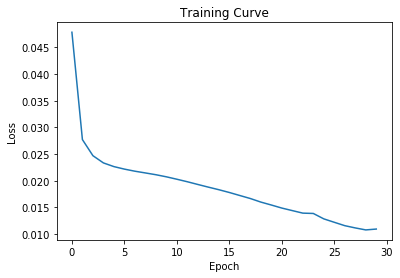

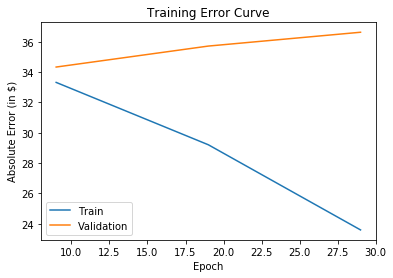

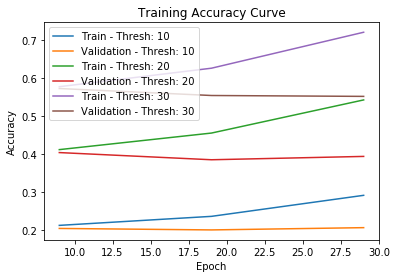

---[ITER 10] loss: 0.013840  time: 12.296
[EPOCH 31] loss: 0.013325  time: 13.970
---[ITER 10] loss: 0.012633  time: 13.180
[EPOCH 32] loss: 0.012506  time: 14.754
---[ITER 10] loss: 0.011282  time: 11.498
[EPOCH 33] loss: 0.010941  time: 12.941
---[ITER 10] loss: 0.010047  time: 11.388
[EPOCH 34] loss: 0.009994  time: 12.980
---[ITER 10] loss: 0.010299  time: 10.132
[EPOCH 35] loss: 0.010138  time: 11.751
---[ITER 10] loss: 0.009683  time: 10.197
[EPOCH 36] loss: 0.009448  time: 11.777
---[ITER 10] loss: 0.009265  time: 11.800
[EPOCH 37] loss: 0.009005  time: 14.463
---[ITER 10] loss: 0.009194  time: 10.707
[EPOCH 38] loss: 0.008939  time: 12.353
---[ITER 10] loss: 0.009072  time: 11.239
[EPOCH 39] loss: 0.008874  time: 12.773
---[ITER 10] loss: 0.009513  time: 11.528
[EPOCH 40] loss: 0.009434  time: 32.234


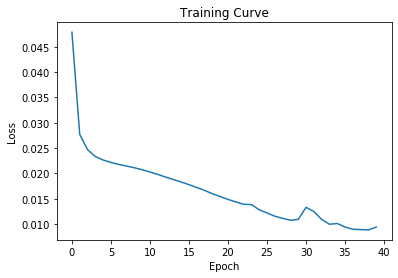

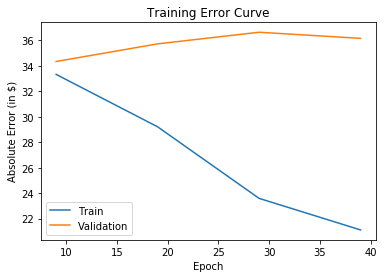

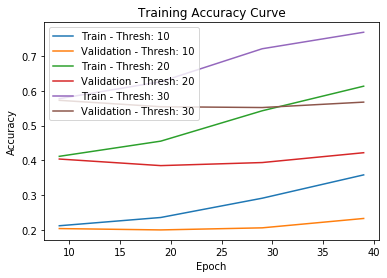

---[ITER 10] loss: 0.009517  time: 10.141
[EPOCH 41] loss: 0.009244  time: 11.727
---[ITER 10] loss: 0.008907  time: 10.318
[EPOCH 42] loss: 0.008587  time: 11.984
---[ITER 10] loss: 0.008769  time: 10.040
[EPOCH 43] loss: 0.008360  time: 12.750
---[ITER 10] loss: 0.008686  time: 11.589
[EPOCH 44] loss: 0.008223  time: 13.221
---[ITER 10] loss: 0.008315  time: 11.524
[EPOCH 45] loss: 0.007959  time: 13.049
---[ITER 10] loss: 0.007829  time: 9.997
[EPOCH 46] loss: 0.007599  time: 11.650
---[ITER 10] loss: 0.007163  time: 9.892
[EPOCH 47] loss: 0.007002  time: 11.430
---[ITER 10] loss: 0.006615  time: 10.180
[EPOCH 48] loss: 0.006396  time: 11.820
---[ITER 10] loss: 0.006060  time: 10.238
[EPOCH 49] loss: 0.005795  time: 11.873
---[ITER 10] loss: 0.005569  time: 10.480
[EPOCH 50] loss: 0.005319  time: 27.383


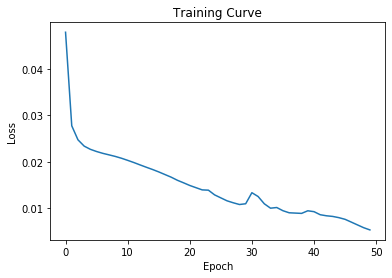

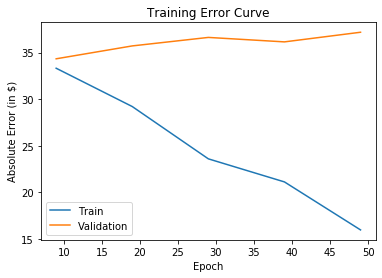

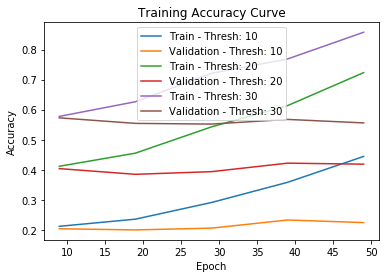

---[ITER 10] loss: 0.005060  time: 10.063
[EPOCH 51] loss: 0.004856  time: 11.563
---[ITER 10] loss: 0.004740  time: 11.347
[EPOCH 52] loss: 0.004588  time: 13.090
---[ITER 10] loss: 0.004551  time: 11.904
[EPOCH 53] loss: 0.004398  time: 14.853
---[ITER 10] loss: 0.004484  time: 14.904
[EPOCH 54] loss: 0.004345  time: 16.523
---[ITER 10] loss: 0.004653  time: 13.917
[EPOCH 55] loss: 0.004562  time: 15.391
---[ITER 10] loss: 0.005499  time: 11.552
[EPOCH 56] loss: 0.005560  time: 13.115
---[ITER 10] loss: 0.009565  time: 10.419
[EPOCH 57] loss: 0.009398  time: 13.073
---[ITER 10] loss: 0.008245  time: 13.902
[EPOCH 58] loss: 0.007915  time: 15.494
---[ITER 10] loss: 0.006368  time: 11.678
[EPOCH 59] loss: 0.005967  time: 13.308
---[ITER 10] loss: 0.004526  time: 11.825
[EPOCH 60] loss: 0.004344  time: 32.857


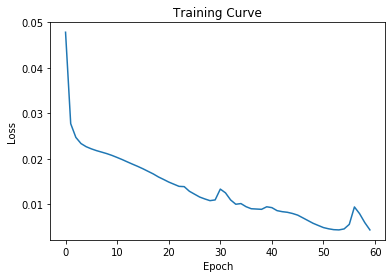

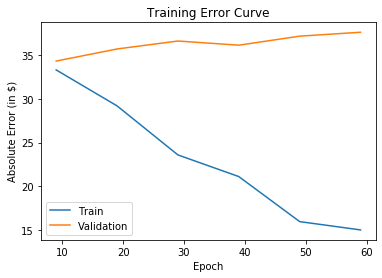

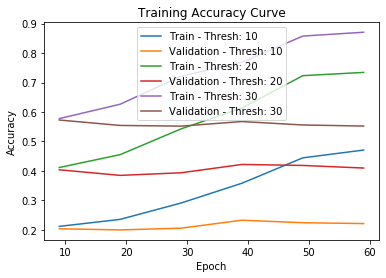

---[ITER 10] loss: 0.004267  time: 15.303
[EPOCH 61] loss: 0.004033  time: 16.953
---[ITER 10] loss: 0.004103  time: 11.919
[EPOCH 62] loss: 0.003946  time: 13.564
---[ITER 10] loss: 0.003602  time: 13.961
[EPOCH 63] loss: 0.003530  time: 15.551
---[ITER 10] loss: 0.003676  time: 12.690
[EPOCH 64] loss: 0.003596  time: 14.785
---[ITER 10] loss: 0.003792  time: 12.543
[EPOCH 65] loss: 0.003676  time: 14.198
---[ITER 10] loss: 0.003931  time: 9.987
[EPOCH 66] loss: 0.003885  time: 11.510
---[ITER 10] loss: 0.004535  time: 9.640
[EPOCH 67] loss: 0.004485  time: 11.320
---[ITER 10] loss: 0.006246  time: 10.227
[EPOCH 68] loss: 0.006447  time: 11.879
---[ITER 10] loss: 0.009072  time: 12.357
[EPOCH 69] loss: 0.009548  time: 13.983
---[ITER 10] loss: 0.012725  time: 12.538
[EPOCH 70] loss: 0.013401  time: 32.269


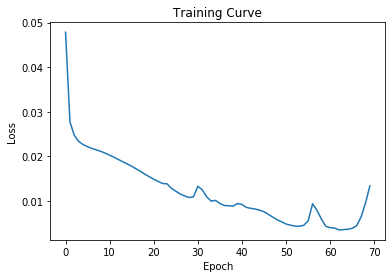

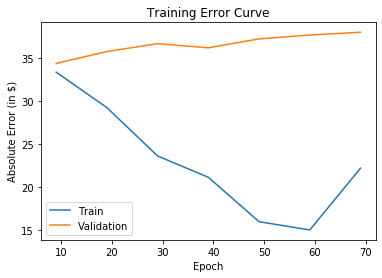

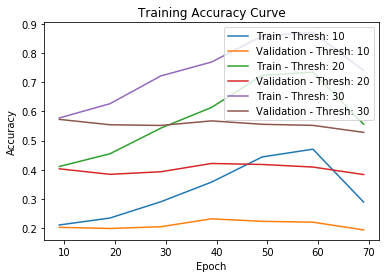

---[ITER 10] loss: 0.010807  time: 12.428
[EPOCH 71] loss: 0.010066  time: 15.202
---[ITER 10] loss: 0.006010  time: 12.783
[EPOCH 72] loss: 0.005856  time: 14.763
---[ITER 10] loss: 0.007330  time: 14.350
[EPOCH 73] loss: 0.007720  time: 16.852
---[ITER 10] loss: 0.006128  time: 23.888
[EPOCH 74] loss: 0.005779  time: 25.608
---[ITER 10] loss: 0.003621  time: 19.404
[EPOCH 75] loss: 0.003570  time: 23.462
---[ITER 10] loss: 0.003850  time: 13.474
[EPOCH 76] loss: 0.003850  time: 16.481
---[ITER 10] loss: 0.004720  time: 11.407
[EPOCH 77] loss: 0.004987  time: 14.458
---[ITER 10] loss: 0.005164  time: 11.866
[EPOCH 78] loss: 0.004974  time: 14.857
---[ITER 10] loss: 0.004798  time: 12.905
[EPOCH 79] loss: 0.004451  time: 15.754
---[ITER 10] loss: 0.004181  time: 10.794
[EPOCH 80] loss: 0.004091  time: 26.996


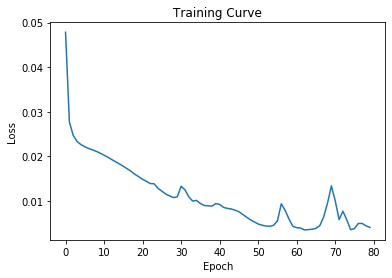

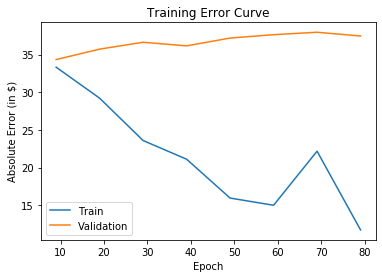

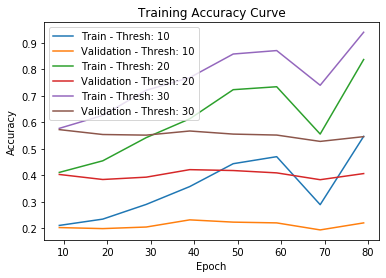

---[ITER 10] loss: 0.003341  time: 9.814
[EPOCH 81] loss: 0.003367  time: 11.468
---[ITER 10] loss: 0.002897  time: 14.480
[EPOCH 82] loss: 0.002903  time: 16.160
---[ITER 10] loss: 0.002929  time: 12.897
[EPOCH 83] loss: 0.002782  time: 14.430
---[ITER 10] loss: 0.003354  time: 13.609
[EPOCH 84] loss: 0.003358  time: 15.099
---[ITER 10] loss: 0.003910  time: 13.894
[EPOCH 85] loss: 0.003986  time: 15.486
---[ITER 10] loss: 0.003847  time: 12.377
[EPOCH 86] loss: 0.003745  time: 15.218
---[ITER 10] loss: 0.003352  time: 10.690
[EPOCH 87] loss: 0.003309  time: 12.120
---[ITER 10] loss: 0.002751  time: 11.348
[EPOCH 88] loss: 0.002743  time: 12.921
---[ITER 10] loss: 0.003037  time: 9.108
[EPOCH 89] loss: 0.003006  time: 10.677
---[ITER 10] loss: 0.002932  time: 9.560
[EPOCH 90] loss: 0.002691  time: 26.069


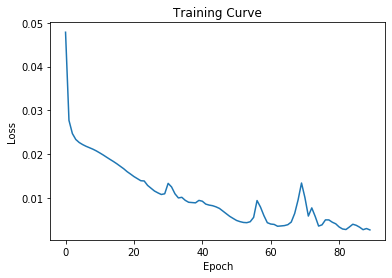

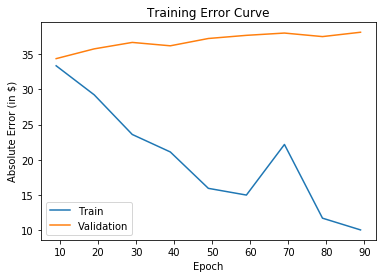

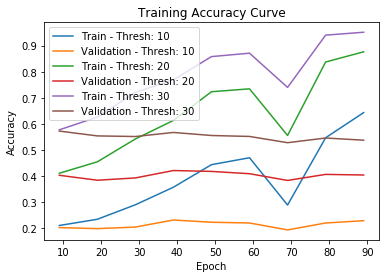

---[ITER 10] loss: 0.002581  time: 10.277
[EPOCH 91] loss: 0.002580  time: 11.827
---[ITER 10] loss: 0.002251  time: 11.867
[EPOCH 92] loss: 0.002293  time: 14.302
---[ITER 10] loss: 0.002104  time: 9.584
[EPOCH 93] loss: 0.001993  time: 11.107
---[ITER 10] loss: 0.002206  time: 9.756
[EPOCH 94] loss: 0.002190  time: 11.188
---[ITER 10] loss: 0.002390  time: 13.212
[EPOCH 95] loss: 0.002373  time: 14.782
---[ITER 10] loss: 0.002345  time: 13.135
[EPOCH 96] loss: 0.002311  time: 14.619
---[ITER 10] loss: 0.002251  time: 12.472
[EPOCH 97] loss: 0.002264  time: 14.027
---[ITER 10] loss: 0.002285  time: 11.453
[EPOCH 98] loss: 0.002196  time: 13.676
---[ITER 10] loss: 0.002423  time: 11.387
[EPOCH 99] loss: 0.002454  time: 13.748
---[ITER 10] loss: 0.002159  time: 11.367
[EPOCH 100] loss: 0.002003  time: 30.935


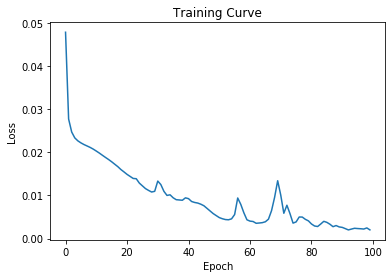

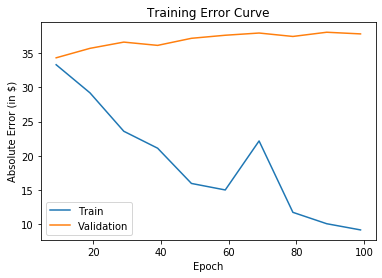

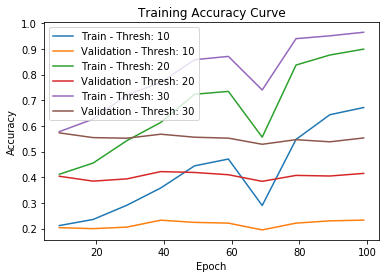

---[ITER 10] loss: 0.001972  time: 11.405
[EPOCH 101] loss: 0.001995  time: 12.886
---[ITER 10] loss: 0.001647  time: 9.448
[EPOCH 102] loss: 0.001611  time: 11.025
---[ITER 10] loss: 0.001536  time: 9.763
[EPOCH 103] loss: 0.001519  time: 11.262
---[ITER 10] loss: 0.001641  time: 10.017
[EPOCH 104] loss: 0.001561  time: 11.985
---[ITER 10] loss: 0.001576  time: 12.750
[EPOCH 105] loss: 0.001590  time: 14.399
---[ITER 10] loss: 0.001500  time: 13.080
[EPOCH 106] loss: 0.001486  time: 14.559
---[ITER 10] loss: 0.001576  time: 11.310
[EPOCH 107] loss: 0.001626  time: 12.985
---[ITER 10] loss: 0.001928  time: 10.449
[EPOCH 108] loss: 0.001908  time: 12.044
---[ITER 10] loss: 0.001988  time: 9.721
[EPOCH 109] loss: 0.001848  time: 11.250
---[ITER 10] loss: 0.001938  time: 9.685
[EPOCH 110] loss: 0.002018  time: 28.830


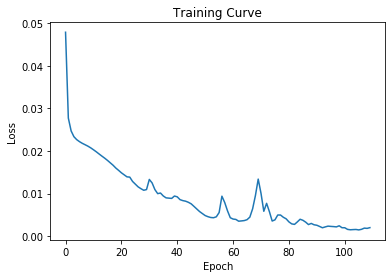

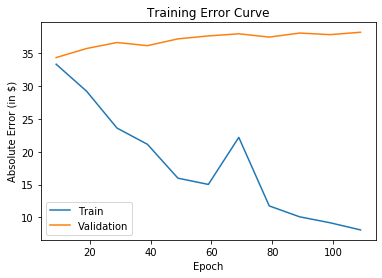

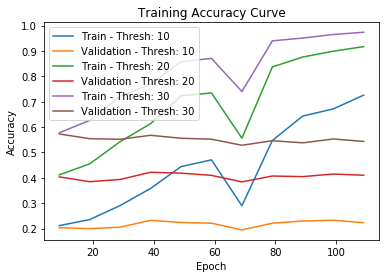

---[ITER 10] loss: 0.001746  time: 13.240
[EPOCH 111] loss: 0.001699  time: 14.733
---[ITER 10] loss: 0.001711  time: 10.508
[EPOCH 112] loss: 0.001675  time: 12.083
---[ITER 10] loss: 0.001711  time: 12.600
[EPOCH 113] loss: 0.001691  time: 14.164
---[ITER 10] loss: 0.001557  time: 9.841
[EPOCH 114] loss: 0.001567  time: 11.414
---[ITER 10] loss: 0.001433  time: 10.439
[EPOCH 115] loss: 0.001394  time: 12.864
---[ITER 10] loss: 0.001425  time: 11.533
[EPOCH 116] loss: 0.001435  time: 13.035
---[ITER 10] loss: 0.001471  time: 11.713
[EPOCH 117] loss: 0.001444  time: 13.364
---[ITER 10] loss: 0.001390  time: 12.528
[EPOCH 118] loss: 0.001355  time: 14.059
---[ITER 10] loss: 0.001502  time: 11.589
[EPOCH 119] loss: 0.001481  time: 13.086
---[ITER 10] loss: 0.001244  time: 14.689
[EPOCH 120] loss: 0.001244  time: 33.077


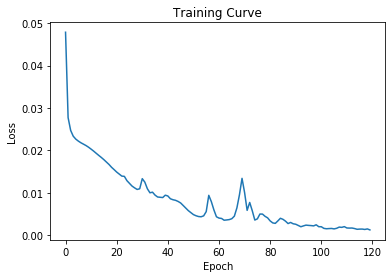

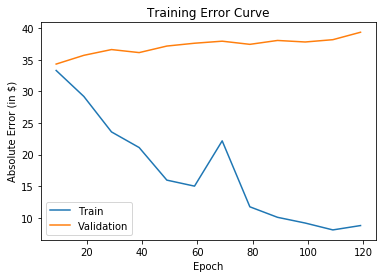

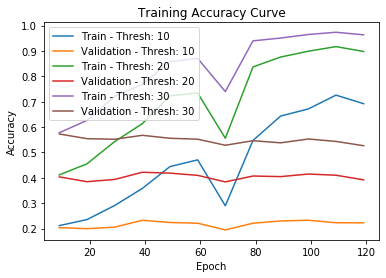

---[ITER 10] loss: 0.001280  time: 11.121
[EPOCH 121] loss: 0.001322  time: 13.000
---[ITER 10] loss: 0.001345  time: 13.345
[EPOCH 122] loss: 0.001320  time: 14.768
---[ITER 10] loss: 0.001406  time: 12.857
[EPOCH 123] loss: 0.001349  time: 14.516
---[ITER 10] loss: 0.001246  time: 13.761
[EPOCH 124] loss: 0.001309  time: 15.502
---[ITER 10] loss: 0.001286  time: 11.127
[EPOCH 125] loss: 0.001279  time: 12.601
---[ITER 10] loss: 0.001346  time: 12.898
[EPOCH 126] loss: 0.001293  time: 14.365
---[ITER 10] loss: 0.001411  time: 9.630
[EPOCH 127] loss: 0.001372  time: 11.715
---[ITER 10] loss: 0.001024  time: 11.971
[EPOCH 128] loss: 0.001062  time: 14.010
---[ITER 10] loss: 0.001068  time: 10.112
[EPOCH 129] loss: 0.001062  time: 11.547
---[ITER 10] loss: 0.001143  time: 9.432
[EPOCH 130] loss: 0.001132  time: 26.061


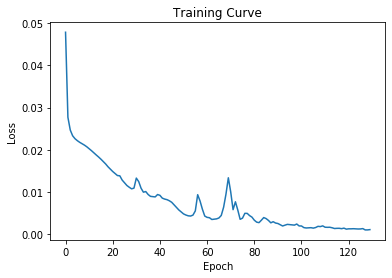

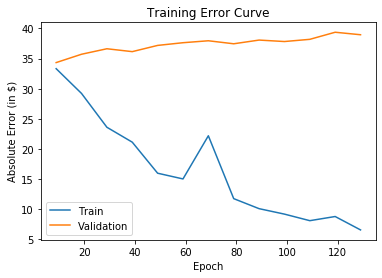

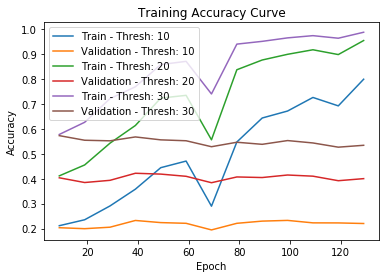

---[ITER 10] loss: 0.001105  time: 9.851
[EPOCH 131] loss: 0.001072  time: 11.434
---[ITER 10] loss: 0.000963  time: 11.559
[EPOCH 132] loss: 0.001101  time: 13.391
---[ITER 10] loss: 0.001048  time: 11.952
[EPOCH 133] loss: 0.001000  time: 13.511
---[ITER 10] loss: 0.001382  time: 11.131
[EPOCH 134] loss: 0.001328  time: 12.696
---[ITER 10] loss: 0.001324  time: 9.603
[EPOCH 135] loss: 0.001289  time: 11.178
---[ITER 10] loss: 0.001039  time: 9.451
[EPOCH 136] loss: 0.001162  time: 11.024
---[ITER 10] loss: 0.001176  time: 11.347
[EPOCH 137] loss: 0.001179  time: 13.136
---[ITER 10] loss: 0.001368  time: 9.680
[EPOCH 138] loss: 0.001285  time: 11.239
---[ITER 10] loss: 0.001177  time: 9.746
[EPOCH 139] loss: 0.001257  time: 12.420
---[ITER 10] loss: 0.000886  time: 10.797
[EPOCH 140] loss: 0.000992  time: 31.295


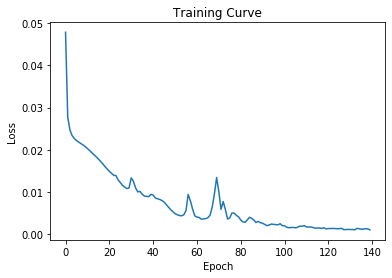

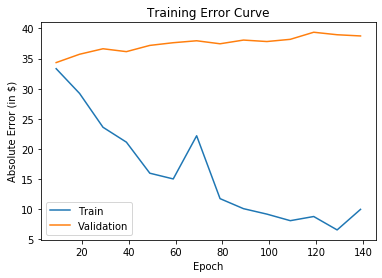

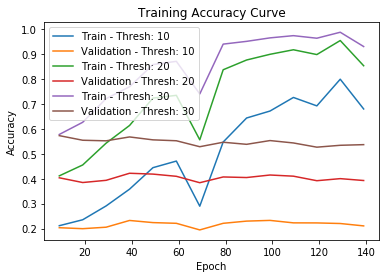

---[ITER 10] loss: 0.001174  time: 12.050
[EPOCH 141] loss: 0.001089  time: 14.269
---[ITER 10] loss: 0.001454  time: 9.725
[EPOCH 142] loss: 0.001405  time: 11.188
---[ITER 10] loss: 0.000984  time: 9.895
[EPOCH 143] loss: 0.001182  time: 12.682
---[ITER 10] loss: 0.001012  time: 11.099
[EPOCH 144] loss: 0.001071  time: 12.506
---[ITER 10] loss: 0.001509  time: 11.790
[EPOCH 145] loss: 0.001433  time: 13.615
---[ITER 10] loss: 0.001358  time: 12.989
[EPOCH 146] loss: 0.001447  time: 14.532
---[ITER 10] loss: 0.001271  time: 12.585
[EPOCH 147] loss: 0.001384  time: 14.064
---[ITER 10] loss: 0.001558  time: 19.601
[EPOCH 148] loss: 0.001627  time: 21.589


KeyboardInterrupt: 

In [35]:
net = airbnb_net()

path = os.getcwd() # get current path
path = path[:-5]+"test/Brian/"
now = datetime.datetime.now()
date = now.strftime("%b").lower()+now.strftime("%d")
i = 1

while True:
    try:
        rootdir = path+"/"+date+"_test"+'{:02d}'.format(i)
        os.mkdir(rootdir)
        break
    except:
        i += 1
        
os.mkdir(rootdir+'/lossplot')
os.mkdir(rootdir+'/checkpoint')
os.mkdir(rootdir+'/accplot')
os.mkdir(rootdir+'/errorplot')
os.mkdir(rootdir+'/final')

#train(net, train_loader, val_loader, [minimum, maximum], rootdir)
torch.manual_seed(1)
train(net, train_loader, val_loader, [min_price, max_price], rootdir, lr = 0.001, num_epoch = 1000)